In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rc('image', interpolation='nearest', origin='lower', cmap = 'hot')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
rcParams = plt.rcParams.copy()

import numpy as np
import posixpath, glob, datetime, os, sys

from astropy.io import fits as pyfits

import sep

from skimage.util import view_as_blocks

from tqdm import tqdm,tqdm_notebook

# Image de-mosaicking and simple de-biasing

In [8]:
def parse_det(string):
    x0,x1,y0,y1 = [int(_)-1 for _ in sum([_.split(':') for _ in string[1:-1].split(',')], [])]
    
    return x0,x1,y0,y1

def load_mosaic(filename, fn=None, subtract_overscans=True, bias=None):
    f = pyfits.open(filename)

    if len(f) == 1:
        header = f[0].header
        image0 = f[0].data.astype(np.double)

        if subtract_overscans and header.get('AVGBIAS'):
            image0 -= header['AVGBIAS']

        if bias is not None:
            image0 -= bias

        if fn and isinstance(fn, types.FunctionType):
            image0 = fn(image0)

    else:
        header0 = f[0].header
        
        if header0.get('DETSIZE'):
            _,iw,_,ih = parse_det(header0['DETSIZE'])
        elif f[1].header.get('DETSIZE'):
            _,iw,_,ih = parse_det(f[1].header['DETSIZE'])
        else:
            print "Can't find DETSIZE keyword"
            return None
            
        iw += 1
        ih += 1
        image0 = np.zeros(shape=(ih,iw))

        for _ in xrange(1,len(f)):
            header = f[_].header
            if not header.get('DATASEC'):
                continue

            image = f[_].data.astype(np.double)

            x0,x1,y0,y1 = parse_det(header['DATASEC'])
            xx0,xx1,yy0,yy1 = parse_det(header['DETSEC'])

            dxx = 1 if xx1 > xx0 else -1
            dyy = 1 if yy1 > yy0 else -1

            if xx1 > xx0:
                dxx = 1
                xx1 += 1
            else:
                dxx = -1
                if xx1 > 0:
                    xx1 -= 1
                else:
                    xx1 = None

            if yy1 > yy0:
                dyy = 1
                yy1 += 1
            else:
                dyy = -1
                if yy1 > 0:
                    yy1 -= 1
                else:
                    yy1 = None

            sub = image[y0:y1+1,x0:x1+1]

            if subtract_overscans:
                sub -= header.get('AVGBIAS', 0.0)
    
            if bias is not None:
                sub -= bias[yy0:yy1:dyy,xx0:xx1:dxx]

            if fn and isinstance(fn, types.FunctionType):
                sub = fn(sub)
            
            image0[yy0:yy1:dyy,xx0:xx1:dxx] = sub

    return image0


# MCMC-based Gaussian fitting

In [9]:
import ngmix
from ngmix.fitting import LMSimple, MCMCSimple

def srandu(num=None):
#  Generate random numbers in the symmetric distribution [-1,1]
    return 2*(np.random.random(num)-0.5)

def get_sigma(img, weight_map=None, xc=4.0, yc=4.0, nwalkers=80, burnin=400, nstep=400):
    guess=np.zeros((nwalkers, 6))

    if weight_map is None:
        weight_map = 1./np.sqrt(np.fabs(img))
        
    obs = ngmix.observation.Observation(img, weight=weight_map)
    mc = MCMCSimple(obs, 'gauss', nwalkers=nwalkers, nsub=4)
    guess[:,0] = xc + 0.1*srandu(nwalkers)
    guess[:,1] = yc + 0.1*srandu(nwalkers)
    guess[:,2] = 0. + 0.1*srandu(nwalkers)
    guess[:,3] = 0. + 0.1*srandu(nwalkers)
    guess[:,4] = 0.32 * (1.0 + 0.1*srandu(nwalkers)) # 0.32 = 2*(0.4)**2
    guess[:,5] = np.sum(img) * (1.0 + 0.1*srandu(nwalkers))

    pos = mc.run_mcmc(guess, burnin)
    pos = mc.run_mcmc(pos,   nstep)

    mc.calc_result()

    result = mc.get_result()

    if result['flags'] == 0:
        return result['pars'][0], result['pars'][1], np.sqrt(result['pars'][4]/2.0)
    else:
        return 0.0, 0.0, 0.0

# Actual Fe55 extraction and measurement code

In [10]:
def make_kernel(r0=1.0):
    x,y = np.mgrid[np.floor(-3.0*r0):np.ceil(3.0*r0+1), np.floor(-3.0*r0):np.ceil(3.0*r0+1)]
    r = np.hypot(x,y)
    image = np.exp(-r**2/2/r0**2)

    return image

def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def process_subimage(sub, gain=1.0):
    kernel = make_kernel(1.0)
    
    bg = sep.Background(sub)
    image1 = sub - bg.back()

    sep.set_extract_pixstack(image1.shape[0]*image1.shape[1])

    obj0 = sep.extract(image1, err=bg.rms(), thresh=10.0, minarea=1, filter_kernel=kernel)

    idx = np.abs(obj0['npix'] - np.median(obj0['npix'])) < 3.0*mad(obj0['npix'])

    fwhm = 2.0*np.sqrt(np.hypot(obj0['a'][idx], obj0['b'][idx])*np.log(2))
    fwhm = np.median(fwhm)

    flux,fluxerr,flag = sep.sum_circle(image1, obj0['x'], obj0['y'], 2.0*fwhm, err=bg.rms(), gain=gain)

    idx &= np.abs(flux - np.median(flux)) < 3.0*mad(flux)
    idx &= (flag == 0)
    # TODO: proper filtering of other peaks

    xs,ys,fluxes = obj0['x'][idx], obj0['y'][idx],flux[idx]

    sigmas = []

    # for iter,_ in enumerate(xrange(len(xs))):
    for _ in tqdm_notebook(xrange(len(xs))):
        x0,y0 = int(np.round(xs[_])),int(np.round(ys[_]))
        img = image[y0-3:y0+4, x0-3:x0+4]
        wmap = 1.0/bg.rms()[y0-3:y0+4, x0-3:x0+4]**2

        x1,y1,sigma1 = get_sigma(img.T, weight_map=wmap.T, xc=xs[_]-x0+3, yc=ys[_]-y0+3, nstep=400)

        sigmas.append(sigma1)

    sigmas = np.array(sigmas)

    return sigmas

# Now apply it to all sub-images of all acquired frames

In [12]:
for filename in sorted(glob.glob('/gpfs/mnt/gpfs01/astro/workarea/ccdtest/prod/ITL-CCD/ITL-3800C-164/*/fe55_acq/v0/*/*.fits')):
    if 'bias' in filename:
        continue
        
    print filename
  
    header = pyfits.getheader(filename, 0)
    gain = header.get('CCDGAIN', 1.0)
    
    # Load and reconstruct the mosaic subtracting overscans
    image = load_mosaic(filename)
    
    geometry = [2,8]
    v = view_as_blocks(image, (image.shape[0]/geometry[0], image.shape[1]/geometry[1]))

    for _ in xrange(geometry[0]):
        for __ in xrange(geometry[1]):
            sub = v[_,__].astype(np.double).copy() # Single amplifier block

            sigmas = process_subimage(sub)
            
            break
        break
    
    break

/gpfs/mnt/gpfs01/astro/workarea/ccdtest/prod/ITL-CCD/ITL-3800C-164/6708/fe55_acq/v0/41382/ITL-3800C-164_fe55_fe55_001_20180202060645.fits


Text(0.5,0,'Sigma')

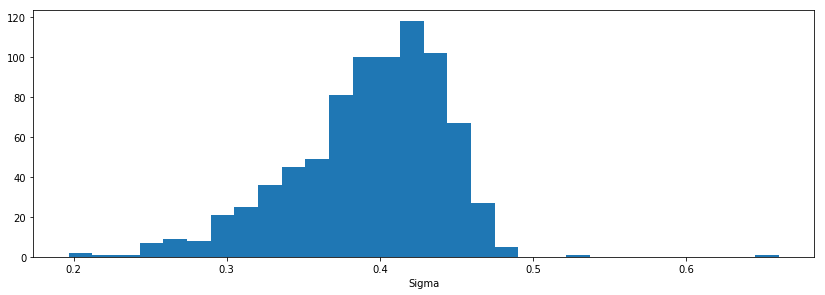

In [13]:
plt.subplot(211)
plt.hist(sigmas, bins=30);
plt.xlabel('Sigma')